##Code Antoine (Oscillateur)

In [1]:
from PIL import Image

import os
from collections import namedtuple
from abc import ABC, abstractmethod
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import tqdm

In [2]:
def save_gif_pil(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs"""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:],
                 save_all=True, duration=int(1000 / fps), loop=loop)

In [3]:
class CauchyProblem(ABC):
    @abstractmethod
    def reference_solution(self, x):
        pass

    @abstractmethod
    def residual(self, ddy, dy, y):
        pass

    @abstractmethod
    def cauchy_conditions(self, dy, y):
        pass


class Oscillator(CauchyProblem):
    """
    Equation
        m y''(x) + mu y'(x) + k y(x) = 0,  x in (0, 1)
    Initial condition
        y(0) = 1
        y'(0) = 1
    Here
        - dumping = mu / 2m
        - pulsation = sqrt(k/m)
    """
    def __init__(self, dumping, pulsation):
        assert dumping < pulsation
        self.d = dumping
        self.w0 = pulsation
        self.y0 = 1.0
        self.dy0 = 0.0

    def reference_solution(self, x):
        """Defines the analytical solution to the 1D underdamped harmonic
        oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
        """
        w = np.sqrt(self.w0 ** 2 - self.d ** 2)
        phi = np.arctan(-self.d / w)
        a = 1 / (2 * np.cos(phi))
        cos = torch.cos(phi + w * x)
        # sin = torch.sin(phi + w * x)
        exp = torch.exp(-self.d * x)
        return exp * 2 * a * cos

    def residual(self, ddy, dy, y):
        mu = 2 * self.d
        k = self.w0 ** 2
        return ddy + mu * dy + k * y

    def cauchy_conditions(self, dy, y):
        return namedtuple("CauchyCond", ["y0", "dy0"])(y[0] - self.y0,
                                                       dy[0] - self.dy0)


In [4]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


class FullyConnectedNetwork(nn.Module):
    """Defines a connected network"""

    def __init__(self, input_dim, output_dim, hidden_dim, nb_layers):
        super().__init__()
        activation = nn.Tanh
        # activations = [nn.Tanh for _ in range(nb_layers - 1)]
        activations = [SinActivation for _ in range(nb_layers - 1)]
        activations[-1] = SinActivation
        self.fcs = nn.Sequential(nn.Linear(input_dim, hidden_dim), activation())
        self.fch = nn.Sequential(
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), act())
              for act in activations])
        self.fce = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [5]:
def plot_result(x_exact, y_exact, xp, yh, epoch, file_name):
    """Pretty plot training results"""
    plt.figure(figsize=(8, 4))
    plt.plot(x_exact, y_exact, color="grey", linewidth=2,
             alpha=0.8,
             label="Exact solution")
    plt.plot(x_exact, yh, color="tab:blue", linewidth=4, alpha=0.8,
             label="Neural network prediction")
    plt.scatter(xp, -0 * torch.ones_like(xp), s=60, color="tab:green",
                alpha=0.4,
                label='Physics loss training locations')
    legend = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (epoch + 1), fontsize="xx-large",
             color="k")
    plt.axis("off")
    plt.savefig(file_name, bbox_inches='tight',
                pad_inches=0.1, dpi=100, facecolor="white")


def plot_losses(losses):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots(2, 2)
    epoch_list = range(len(losses.residual))
    ax[0][0].semilogy(epoch_list, losses.total,
                      color="black",
                      label="Total loss")
    ax[0][1].semilogy(epoch_list, losses.residual,
                      color="red",
                      label="loss residual")
    ax[1][0].semilogy(epoch_list, losses.init_value,
                      color="green",
                      label="loss (y[0] - 1)**2")
    ax[1][1].semilogy(epoch_list, losses.init_derivative,
                      color="green",
                      label="loss dy/dx[0]**2")
    [(a.grid(), a.legend()) for aa in ax for a in aa]
    fig.savefig("loss_convergence")

In [6]:

def train_from_data(cauchy_problem: CauchyProblem):
    plots_dir = "./plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # generate data
    # get the analytical solution over the full domain
    nx = 500
    x = torch.linspace(0, 1, nx).view(-1, 1)
    y = cauchy_problem.reference_solution(x).view(-1, 1)

    # slice out a small number of points from the LHS of the domain
    n_data = 50
    idx = [int(z) for z in np.linspace(0, nx - 1, n_data)]
    x_data = x[idx]
    y_data = y[idx]

    # plot exact solution and the data
    plt.figure()
    plt.plot(x, y, label="Exact solution")
    plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
    plt.legend()
    plt.savefig("exact_sol_and_data")

    # train standard neural network to fit training data
    model = FullyConnectedNetwork(input_dim=1, output_dim=1,
                                  hidden_dim=32,
                                  nb_layers=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    files = []
    n_epoch = 10_000
    for epoch in tqdm.tqdm(range(n_epoch)):
        optimizer.zero_grad()
        yh = model(x_data)
        loss = torch.mean((yh - y_data) ** 2)  # use mean squared error
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
        if (epoch + 1) % (n_epoch // 100) == 0:

            yh = model(x).detach()

            file_name = f"{plots_dir}/nn_{epoch + 1:8i}.png"
            plot_result(x_exact=x, y_exact=y,
                        xp=x_data, yh=yh,
                        epoch=epoch, file_name=file_name)

            files.append(file_name)

    save_gif_pil("nn.gif", files, fps=20, loop=0)


class SavedLosses:
    def __init__(self):
        self.total = []
        self.residual = []
        self.init_value = []
        self.init_derivative = []

    def save(self, total, residual, init_value, init_derivative):
        self.total.append(total)
        self.residual.append(residual)
        self.init_value.append(init_value)
        self.init_derivative.append(init_derivative)







In [7]:
def train_pinns(cauchy_problem: CauchyProblem):
    plots_dir = "./plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    # get the analytical solution over the full domain
    n_pts = 500
    x_exact = torch.linspace(0, 1, n_pts).view(-1, 1).requires_grad_(True)
    y_exact = cauchy_problem.reference_solution(x_exact).view(-1, 1)

    # sample locations over the problem domain
    n_col_pts = 30
    collocation_pts = torch.linspace(0, 1,
                                     n_col_pts,
                                     requires_grad=True).view(-1, 1)

    model = FullyConnectedNetwork(input_dim=1,
                                  output_dim=1,
                                  hidden_dim=32,
                                  nb_layers=3)

    coef_loss_residual = 5*1e-5   #Original value = 1e-5
    coef_loss_y0 = 1e1
    coef_loss_dy0 = 1e-4

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    n_epoch = 28_000

    def lr_multiplier(epoch):
        return 1 ** (epoch / n_epoch)

    scheduler = lr_scheduler.LambdaLR(optimizer,
                                      lr_lambda=lr_multiplier)
    files = []
    losses = SavedLosses()
    for epoch in tqdm.tqdm(range(n_epoch)):
        optimizer.zero_grad()
        y = model(collocation_pts)
        # computes dy/dx
        dy = torch.autograd.grad(y, collocation_pts,
                                 torch.ones_like(y),
                                 create_graph=True)[0]

        # computes d^2y/dx^2
        ddy = torch.autograd.grad(dy, collocation_pts,
                                  torch.ones_like(dy),
                                  create_graph=True)[0]

        # computes the residual of the 1D harmonic oscillator differential
        residual = cauchy_problem.residual(ddy, dy, y)
        loss_residual = torch.mean(residual ** 2)
        cauchy_cond = cauchy_problem.cauchy_conditions(dy, y)
        loss_y0, loss_dy0 = cauchy_cond.y0 ** 2, cauchy_cond.dy0 ** 2

        # backpropagate joint loss
        loss = (coef_loss_residual * loss_residual
                + coef_loss_y0 * loss_y0
                + coef_loss_dy0 * loss_dy0)

        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.save(total=loss.item(),
                    residual=loss_residual.item(),
                    init_value=loss_y0.item(),
                    init_derivative=loss_dy0.item())

        # plot the result as training progresses
        if (epoch + 1) % 500 == 0:
            print("")
            print(f"* Learning rate = {optimizer.param_groups[0]['lr']:.2e}")
            print(f"* Losses")
            print(f"    - Residual loss     = "
                  f"{loss_residual.item():.2e}")
            print(f"    - Initial cond loss = "
                  f"{loss_y0.item():.2e}   {loss_dy0.item():.2e}")
            print(f"=> Total weighted loss = {loss.item():.2e}")
            yh = model(x_exact).detach()
            xp = collocation_pts.detach()

            file_name = f"{plots_dir}/pinn_{epoch + 1:8d}.png"
            plot_result(x_exact=x_exact.detach().numpy(),
                        y_exact=y_exact.detach().numpy(),
                        xp=xp, yh=yh, epoch=epoch,
                        file_name=file_name)
            files.append(file_name)

    save_gif_pil("pinn.gif", files, fps=20, loop=0)
    plot_losses(losses)

  2%|▏         | 499/28000 [00:01<01:18, 349.97it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.73e+04
    - Initial cond loss = 2.86e-02   1.46e+00
=> Total weighted loss = 1.65e+00


  4%|▎         | 997/28000 [00:03<01:18, 343.06it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.53e+04
    - Initial cond loss = 2.52e-02   1.98e+00
=> Total weighted loss = 1.52e+00


  5%|▌         | 1519/28000 [00:05<02:01, 217.07it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.88e+04
    - Initial cond loss = 1.66e-02   5.02e+00
=> Total weighted loss = 1.10e+00


  7%|▋         | 2020/28000 [00:07<01:44, 249.53it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.29e+04
    - Initial cond loss = 6.29e-03   1.85e+01
=> Total weighted loss = 7.12e-01


  9%|▉         | 2512/28000 [00:08<01:45, 241.86it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.04e+04
    - Initial cond loss = 4.04e-03   3.72e+01
=> Total weighted loss = 5.66e-01


 11%|█         | 2987/28000 [00:10<01:52, 222.75it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.60e+03
    - Initial cond loss = 2.25e-03   7.19e+01
=> Total weighted loss = 4.60e-01


 12%|█▏        | 3495/28000 [00:12<01:14, 330.12it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 7.14e+03
    - Initial cond loss = 1.40e-03   1.04e+02
=> Total weighted loss = 3.82e-01


 14%|█▍        | 4001/28000 [00:14<01:35, 251.84it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.82e+03
    - Initial cond loss = 4.74e-04   5.06e+01
=> Total weighted loss = 1.51e-01


 16%|█▌        | 4493/28000 [00:15<01:16, 308.22it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.00e+03
    - Initial cond loss = 6.27e-05   2.45e+01
=> Total weighted loss = 5.32e-02


 18%|█▊        | 5000/28000 [00:18<01:51, 205.48it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.94e+02
    - Initial cond loss = 3.37e-05   1.76e+01
=> Total weighted loss = 4.68e-02


 20%|█▉        | 5489/28000 [00:19<01:05, 345.99it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.49e+02
    - Initial cond loss = 3.18e-05   1.31e+01
=> Total weighted loss = 4.41e-02


 21%|██▏       | 5980/28000 [00:21<01:05, 336.15it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.07e+02
    - Initial cond loss = 2.90e-05   9.79e+00
=> Total weighted loss = 4.16e-02


 23%|██▎       | 6499/28000 [00:23<01:15, 284.41it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 7.65e+02
    - Initial cond loss = 2.62e-05   7.18e+00
=> Total weighted loss = 3.92e-02


 25%|██▍       | 6999/28000 [00:24<00:59, 351.69it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 7.23e+02
    - Initial cond loss = 2.36e-05   5.14e+00
=> Total weighted loss = 3.69e-02


 27%|██▋       | 7508/28000 [00:26<01:21, 251.79it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 6.83e+02
    - Initial cond loss = 2.07e-05   3.52e+00
=> Total weighted loss = 3.47e-02


 29%|██▊       | 8007/28000 [00:28<01:24, 236.77it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 6.47e+02
    - Initial cond loss = 1.79e-05   2.21e+00
=> Total weighted loss = 3.27e-02


 30%|███       | 8517/28000 [00:29<01:15, 257.80it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 6.12e+02
    - Initial cond loss = 1.52e-05   1.30e+00
=> Total weighted loss = 3.09e-02


 32%|███▏      | 9005/28000 [00:31<01:24, 224.64it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 5.71e+02
    - Initial cond loss = 1.26e-05   7.74e-01
=> Total weighted loss = 2.87e-02


 34%|███▍      | 9494/28000 [00:32<00:52, 349.20it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 5.04e+02
    - Initial cond loss = 9.58e-06   5.11e-01
=> Total weighted loss = 2.53e-02


 36%|███▌      | 10017/28000 [00:35<01:40, 178.58it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 4.06e+02
    - Initial cond loss = 6.79e-06   5.67e-01
=> Total weighted loss = 2.04e-02


 37%|███▋      | 10482/28000 [00:36<00:48, 359.66it/s]<ipython-input-5-5b9ae46b82ab>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))



* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.94e+02
    - Initial cond loss = 6.23e-06   6.45e-01
=> Total weighted loss = 1.48e-02


 39%|███▉      | 10988/28000 [00:38<00:50, 339.69it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.59e+02
    - Initial cond loss = 3.05e-06   1.42e-01
=> Total weighted loss = 7.99e-03


 41%|████      | 11513/28000 [00:40<01:08, 242.39it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 5.73e+01
    - Initial cond loss = 5.78e-07   4.53e-03
=> Total weighted loss = 2.87e-03


 43%|████▎     | 11983/28000 [00:41<00:46, 343.97it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 3.37e+01
    - Initial cond loss = 7.92e-07   4.86e-04
=> Total weighted loss = 1.69e-03


 45%|████▍     | 12518/28000 [00:43<01:01, 250.29it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.28e+01
    - Initial cond loss = 5.75e-08   7.22e-04
=> Total weighted loss = 1.14e-03


 46%|████▋     | 13011/28000 [00:44<01:02, 240.01it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.56e+01
    - Initial cond loss = 2.16e-06   1.78e-03
=> Total weighted loss = 8.03e-04


 48%|████▊     | 13477/28000 [00:46<01:03, 228.87it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.10e+01
    - Initial cond loss = 4.91e-07   2.13e-03
=> Total weighted loss = 5.56e-04


 50%|█████     | 14019/28000 [00:49<01:00, 230.24it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 7.52e+00
    - Initial cond loss = 2.25e-08   1.78e-03
=> Total weighted loss = 3.76e-04


 52%|█████▏    | 14508/28000 [00:51<00:55, 241.90it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 4.80e+00
    - Initial cond loss = 2.33e-09   8.42e-04
=> Total weighted loss = 2.40e-04


 54%|█████▎    | 15002/28000 [00:52<00:54, 238.20it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.86e+00
    - Initial cond loss = 3.73e-09   3.04e-04
=> Total weighted loss = 1.43e-04


 55%|█████▌    | 15500/28000 [00:54<00:50, 248.32it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.65e+00
    - Initial cond loss = 3.06e-07   1.78e-04
=> Total weighted loss = 8.54e-05


 57%|█████▋    | 16000/28000 [00:55<00:48, 246.56it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.20e-01
    - Initial cond loss = 4.58e-10   2.86e-05
=> Total weighted loss = 4.10e-05


 59%|█████▉    | 16490/28000 [00:57<00:33, 341.58it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 4.14e-01
    - Initial cond loss = 6.97e-10   6.56e-06
=> Total weighted loss = 2.07e-05


 61%|██████    | 16994/28000 [00:59<00:42, 258.01it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.09e-01
    - Initial cond loss = 6.96e-11   1.96e-06
=> Total weighted loss = 1.05e-05


 62%|██████▏   | 17488/28000 [01:01<00:31, 331.94it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 1.11e-01
    - Initial cond loss = 8.87e-11   5.12e-07
=> Total weighted loss = 5.54e-06


 64%|██████▍   | 18011/28000 [01:02<00:41, 242.51it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 8.79e-02
    - Initial cond loss = 4.31e-08   1.25e-06
=> Total weighted loss = 4.83e-06


 66%|██████▌   | 18500/28000 [01:04<00:40, 236.68it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 4.43e-02
    - Initial cond loss = 5.63e-10   9.35e-09
=> Total weighted loss = 2.22e-06


 68%|██████▊   | 19002/28000 [01:06<00:35, 251.17it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 3.58e-02
    - Initial cond loss = 3.38e-08   6.68e-06
=> Total weighted loss = 2.13e-06


 70%|██████▉   | 19498/28000 [01:07<00:24, 344.93it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.99e-02
    - Initial cond loss = 7.13e-10   3.73e-08
=> Total weighted loss = 1.50e-06


 71%|███████▏  | 19991/28000 [01:09<00:23, 345.77it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.77e-02
    - Initial cond loss = 9.06e-10   9.21e-07
=> Total weighted loss = 1.39e-06


 73%|███████▎  | 20501/28000 [01:11<00:43, 171.27it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.66e-02
    - Initial cond loss = 7.19e-10   1.24e-07
=> Total weighted loss = 1.33e-06


 75%|███████▌  | 21017/28000 [01:13<00:29, 234.79it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.58e-02
    - Initial cond loss = 1.73e-09   1.08e-06
=> Total weighted loss = 1.31e-06


 77%|███████▋  | 21507/28000 [01:14<00:27, 238.29it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.52e-02
    - Initial cond loss = 9.13e-10   8.20e-07
=> Total weighted loss = 1.27e-06


 79%|███████▊  | 21988/28000 [01:16<00:23, 252.34it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.48e-02
    - Initial cond loss = 2.16e-11   5.48e-07
=> Total weighted loss = 1.24e-06


 80%|████████  | 22512/28000 [01:18<00:24, 220.60it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.44e-02
    - Initial cond loss = 1.64e-11   5.53e-07
=> Total weighted loss = 1.22e-06


 82%|████████▏ | 23002/28000 [01:20<00:20, 241.32it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.41e-02
    - Initial cond loss = 1.77e-10   9.14e-07
=> Total weighted loss = 1.21e-06


 84%|████████▍ | 23474/28000 [01:22<00:15, 297.16it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 3.18e-02
    - Initial cond loss = 2.03e-08   8.66e-06
=> Total weighted loss = 1.79e-06


 86%|████████▌ | 24000/28000 [01:24<00:19, 205.70it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.93e-02
    - Initial cond loss = 1.47e-07   7.84e-06
=> Total weighted loss = 2.94e-06


 87%|████████▋ | 24487/28000 [01:26<00:10, 332.26it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.39e-02
    - Initial cond loss = 3.64e-12   5.07e-08
=> Total weighted loss = 1.19e-06


 89%|████████▉ | 25015/28000 [01:28<00:12, 237.16it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.35e-02
    - Initial cond loss = 1.58e-08   2.48e-07
=> Total weighted loss = 1.33e-06


 91%|█████████ | 25512/28000 [01:29<00:10, 244.08it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 7.90e-02
    - Initial cond loss = 2.15e-06   1.54e-04
=> Total weighted loss = 2.55e-05


 93%|█████████▎| 26011/28000 [01:31<00:08, 239.08it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.30e-02
    - Initial cond loss = 7.49e-09   1.70e-08
=> Total weighted loss = 1.22e-06


 95%|█████████▍| 26510/28000 [01:33<00:06, 239.53it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.31e-02
    - Initial cond loss = 1.57e-08   1.99e-07
=> Total weighted loss = 1.31e-06


 96%|█████████▋| 26997/28000 [01:34<00:03, 316.52it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.31e-02
    - Initial cond loss = 3.46e-08   3.20e-06
=> Total weighted loss = 1.50e-06


 98%|█████████▊| 27501/28000 [01:36<00:02, 211.57it/s]


* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.63e-02
    - Initial cond loss = 1.31e-07   1.70e-05
=> Total weighted loss = 2.63e-06


100%|██████████| 28000/28000 [01:38<00:00, 284.46it/s]



* Learning rate = 1.00e-04
* Losses
    - Residual loss     = 2.23e-02
    - Initial cond loss = 3.14e-09   4.34e-07
=> Total weighted loss = 1.15e-06
done!


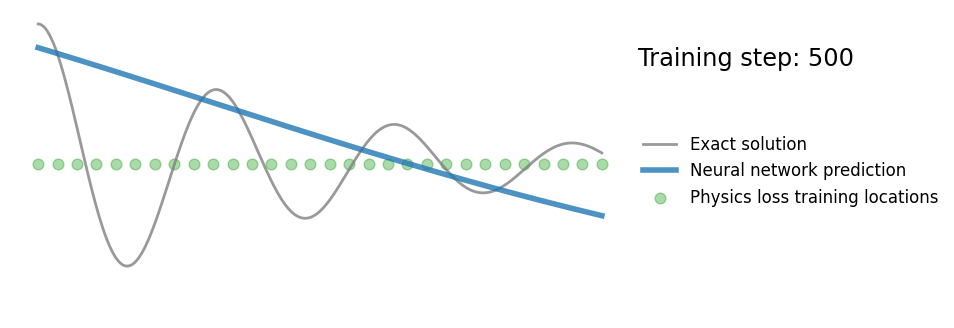

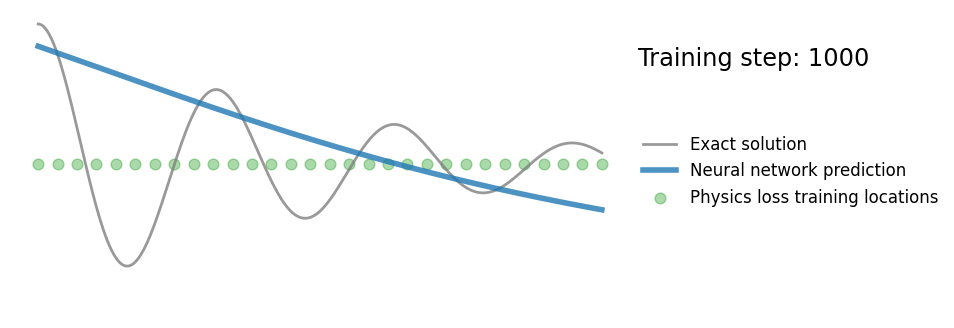

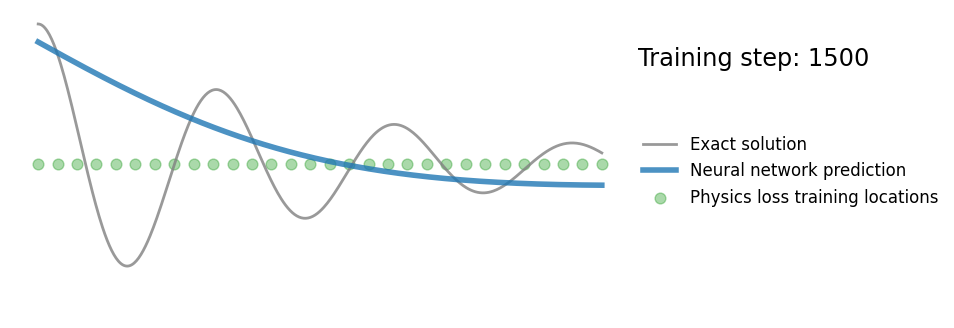

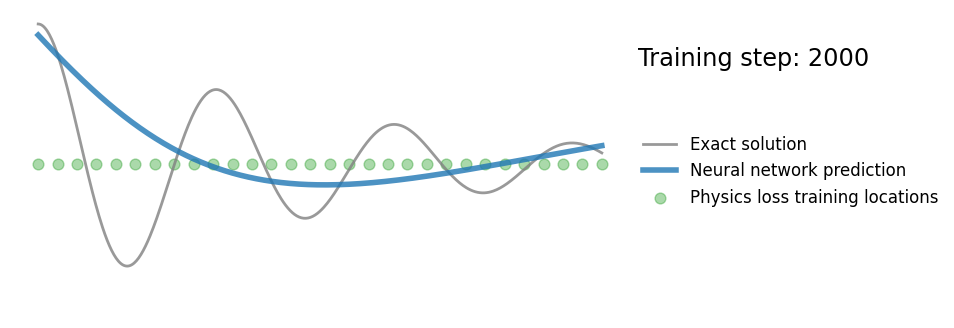

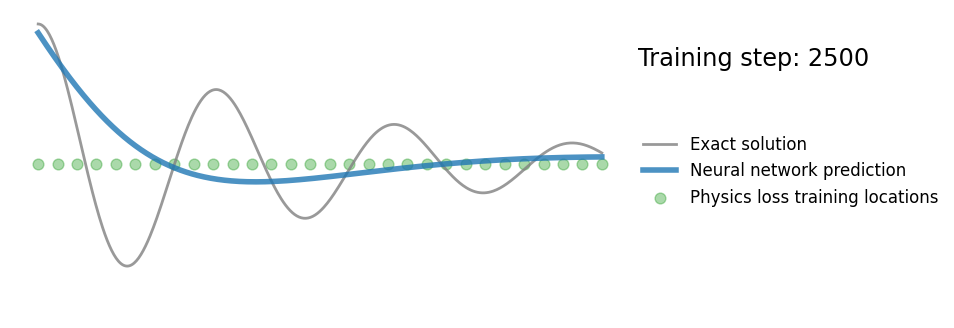

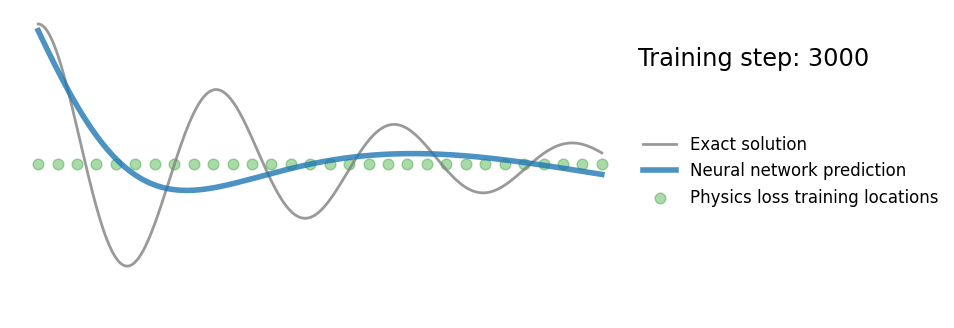

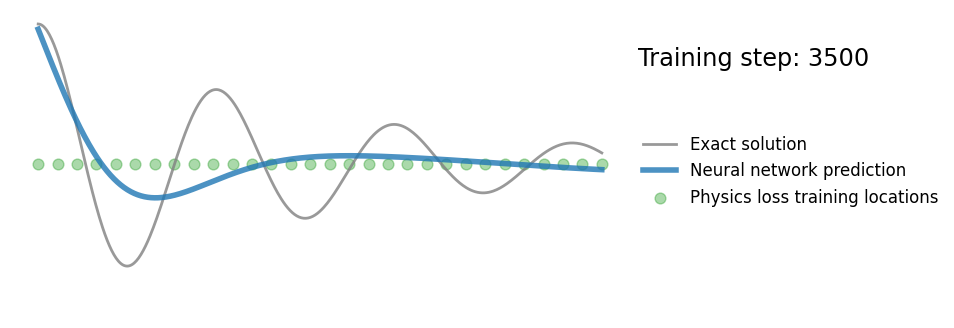

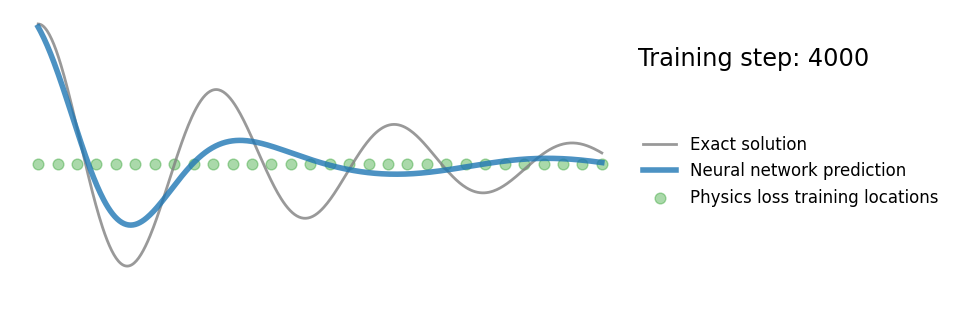

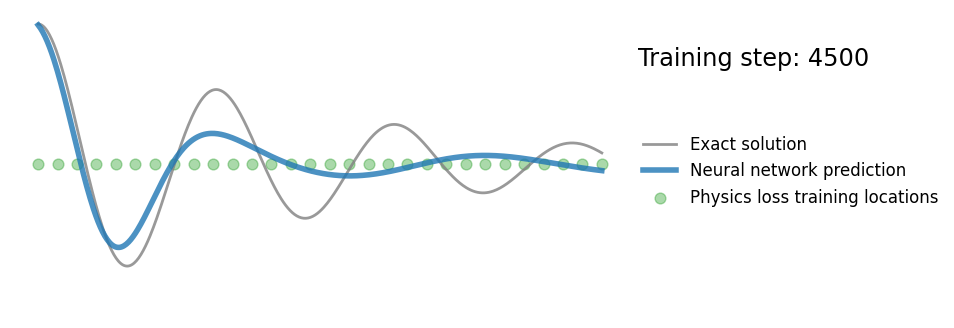

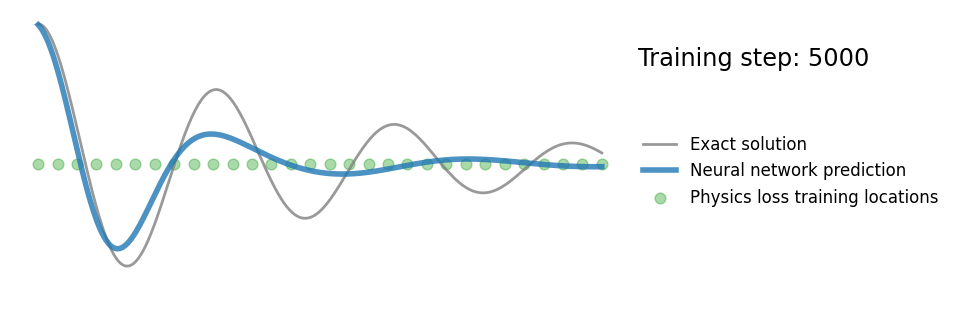

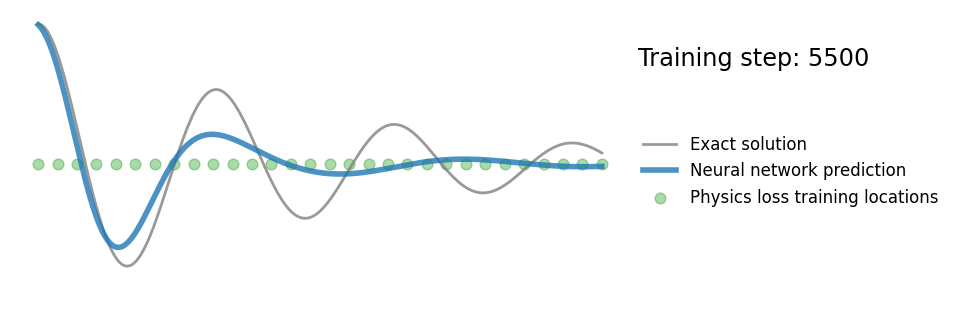

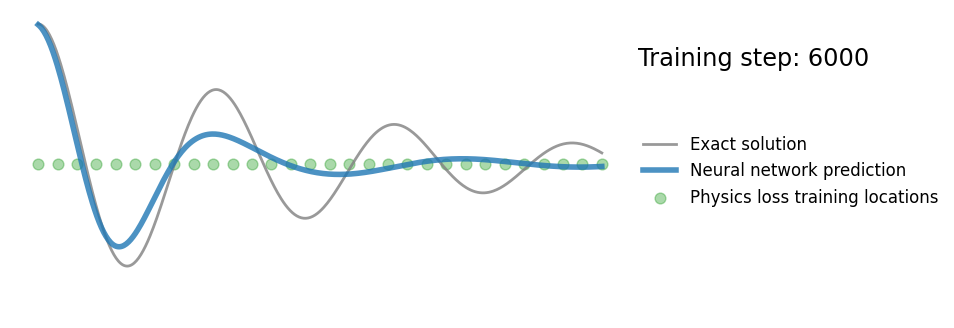

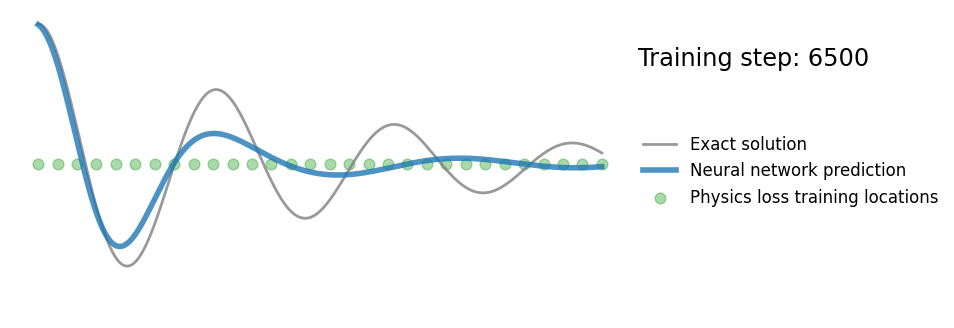

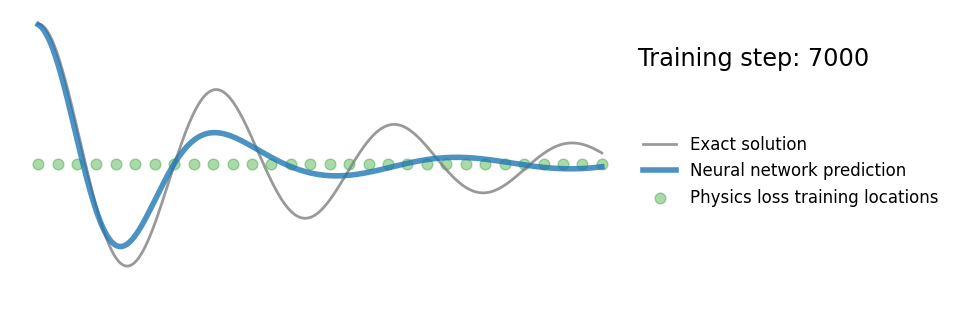

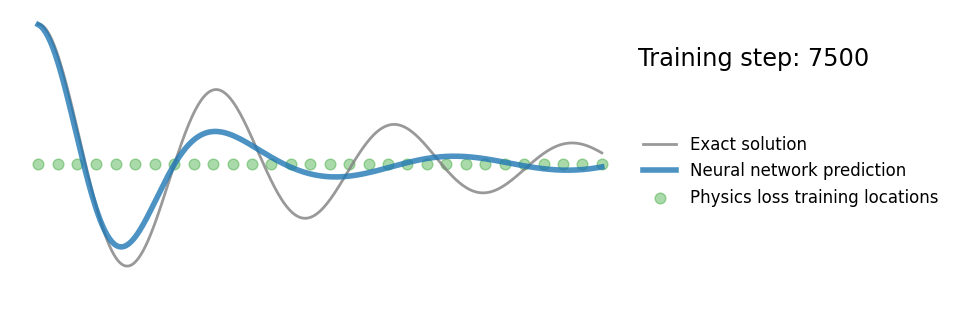

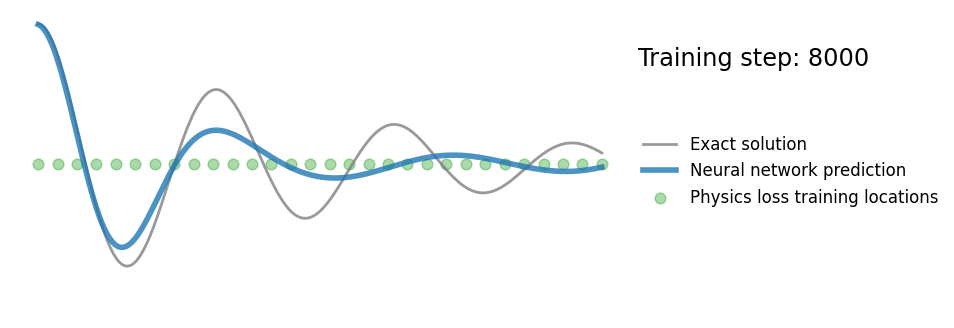

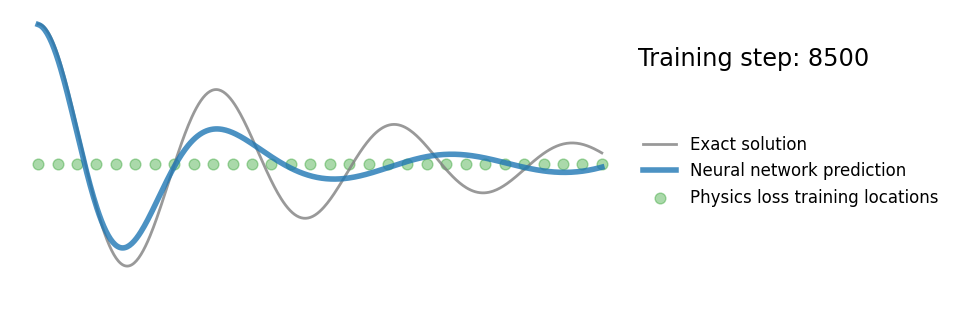

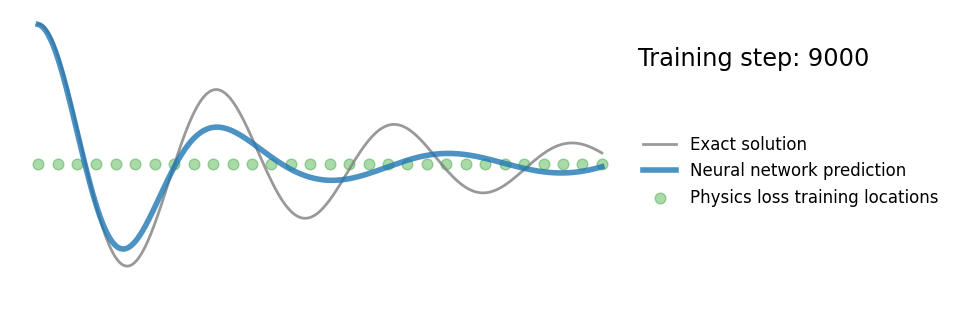

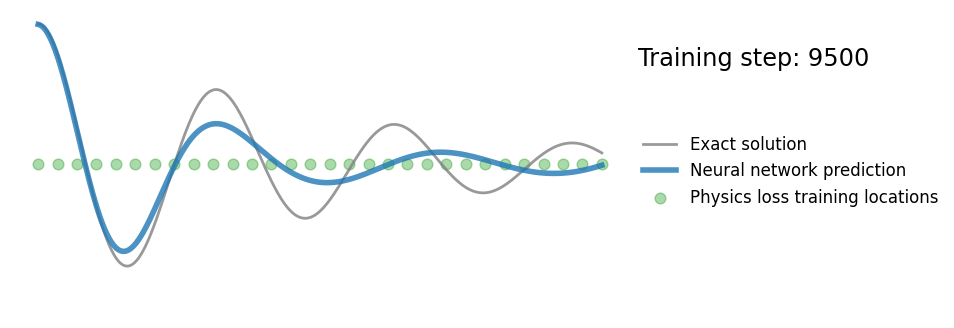

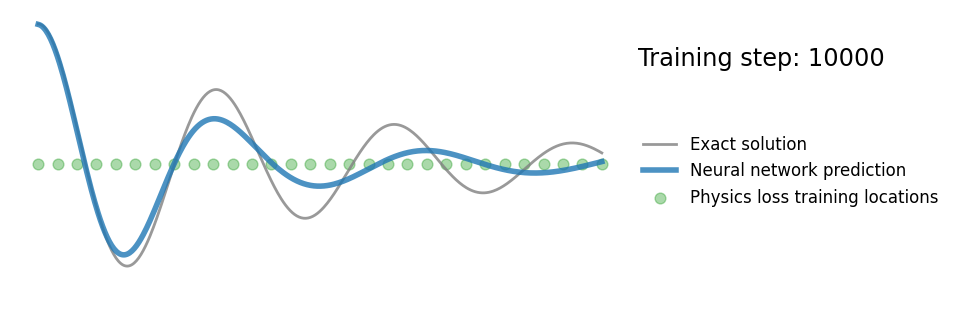

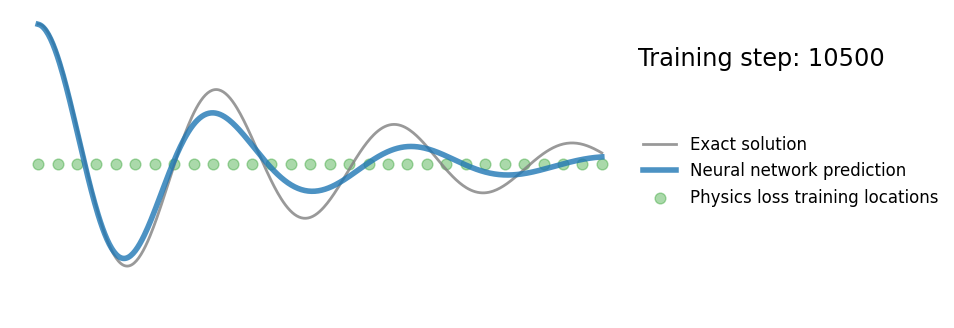

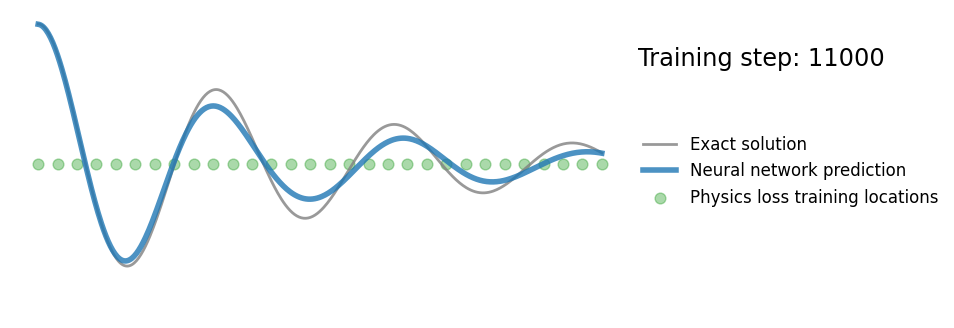

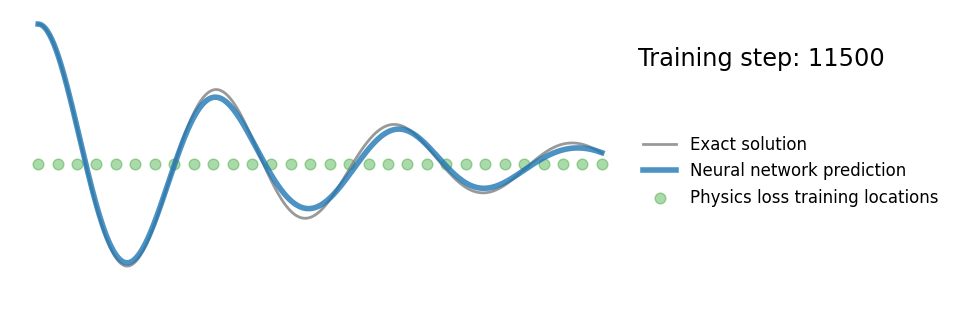

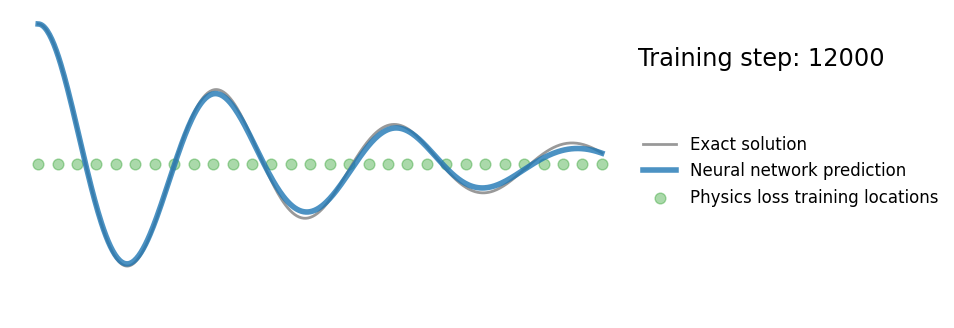

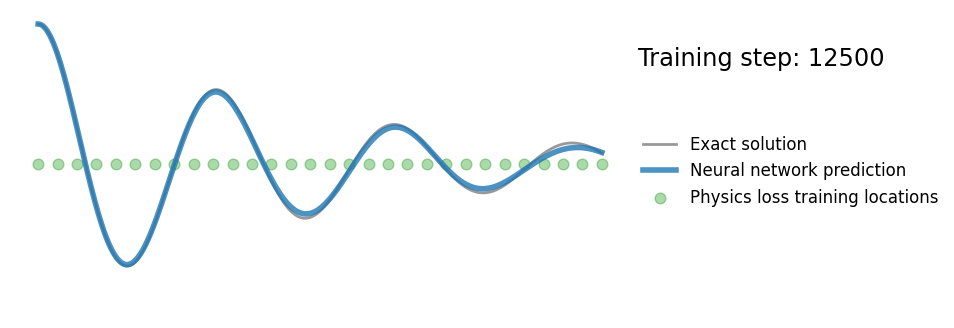

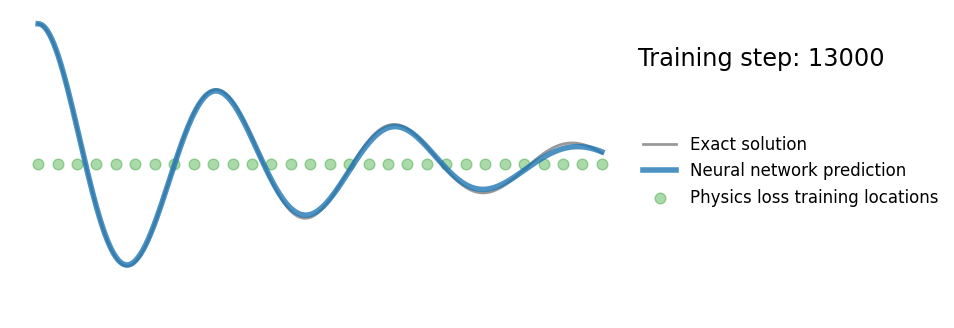

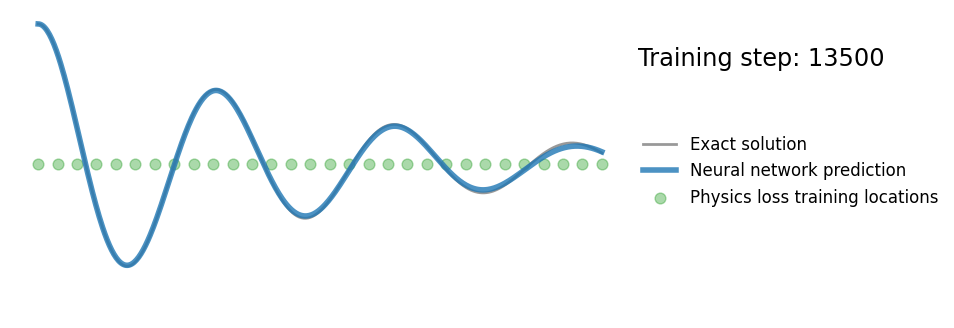

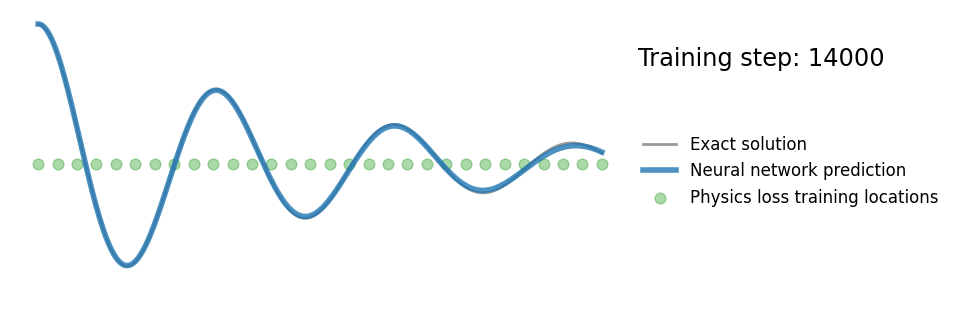

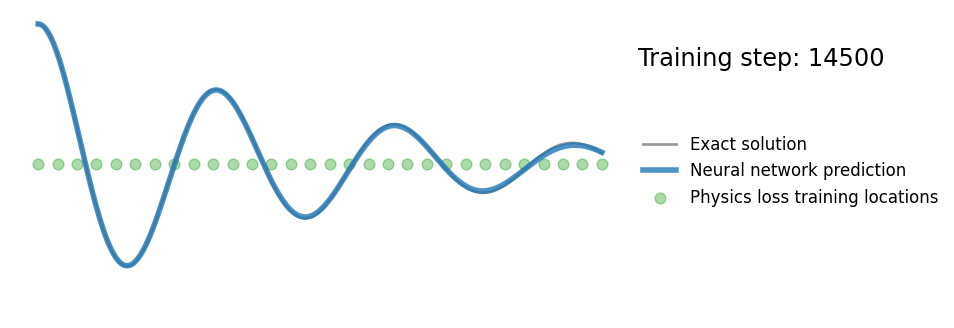

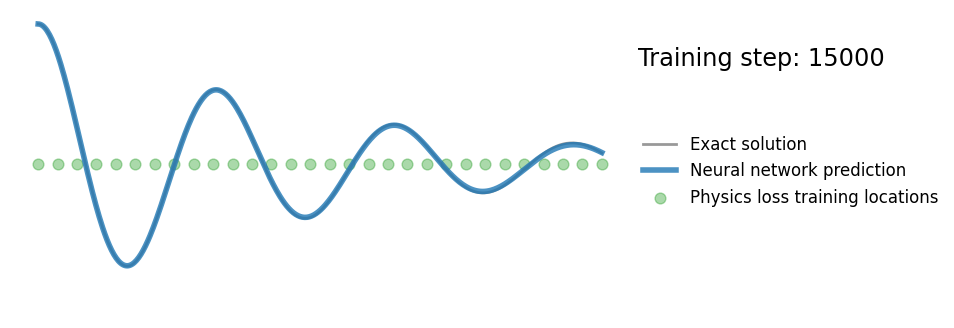

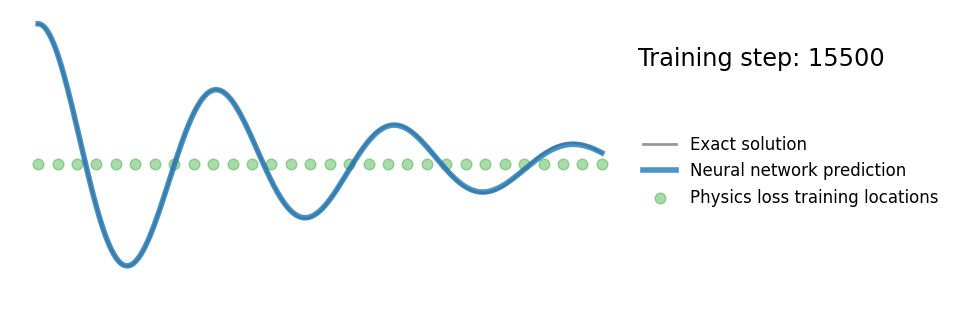

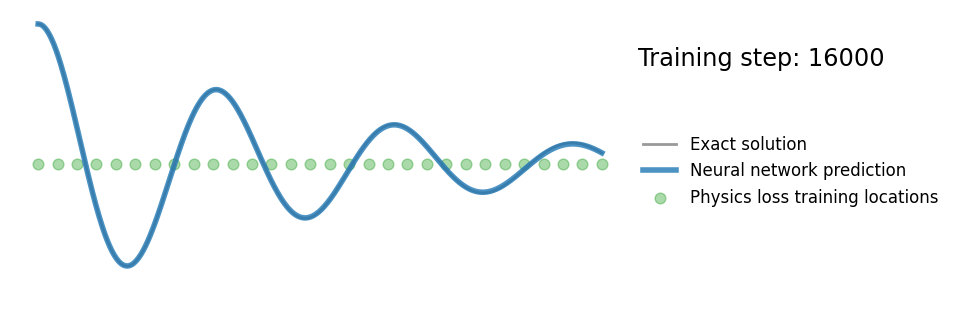

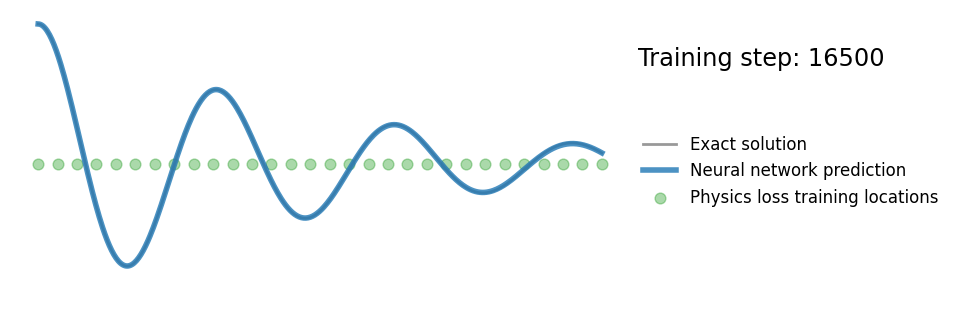

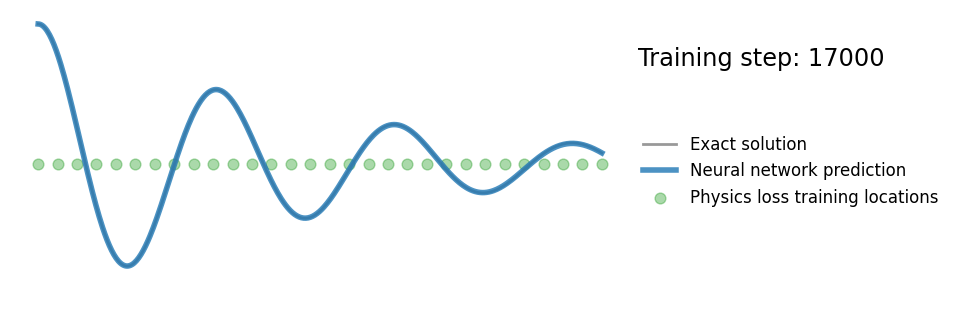

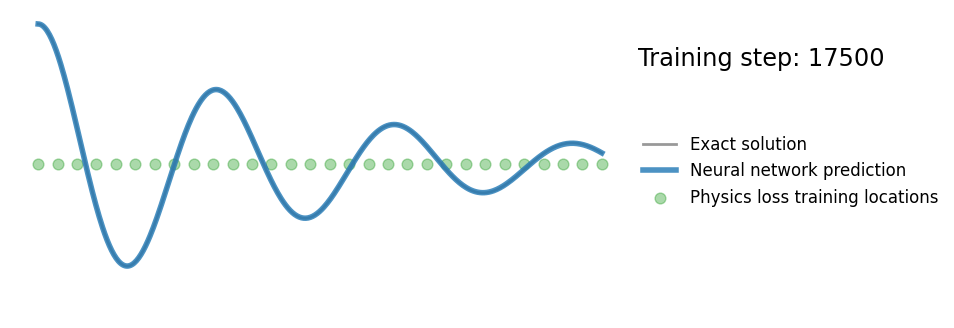

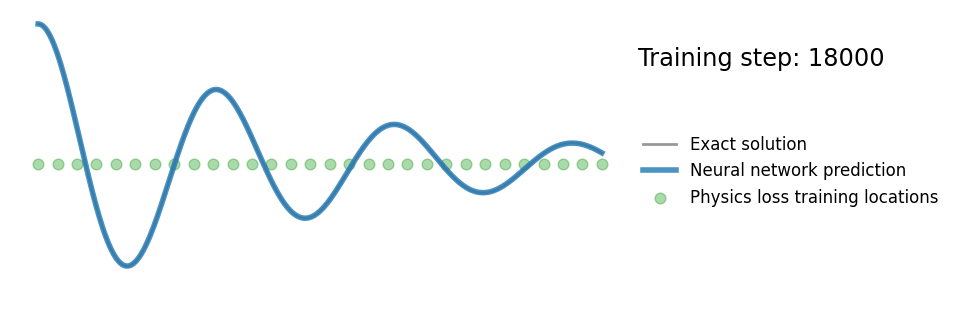

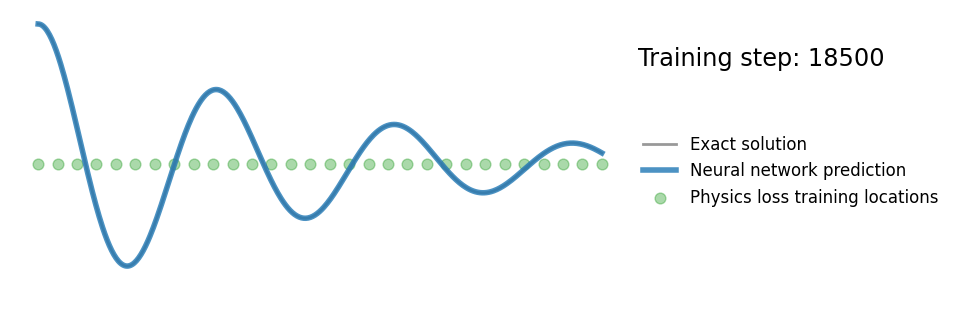

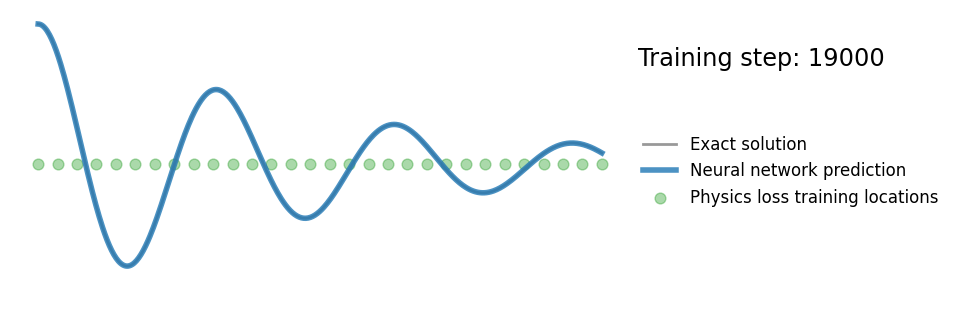

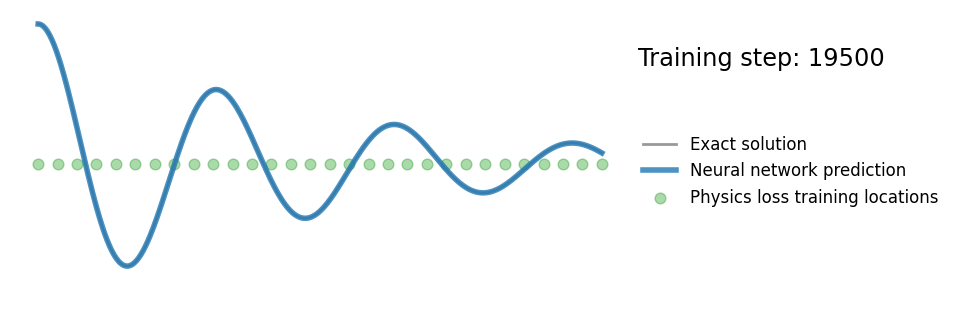

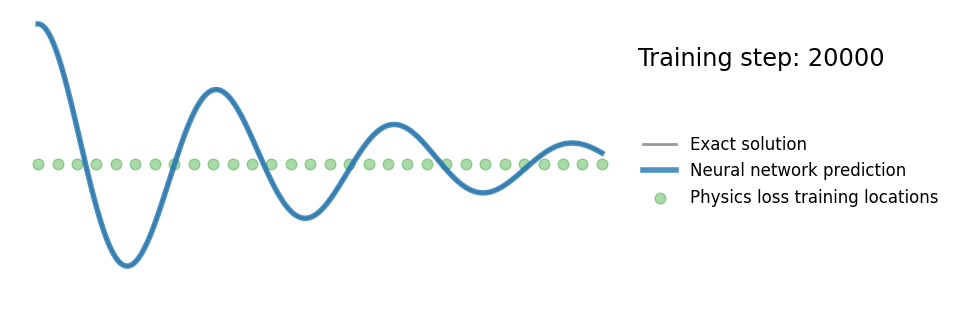

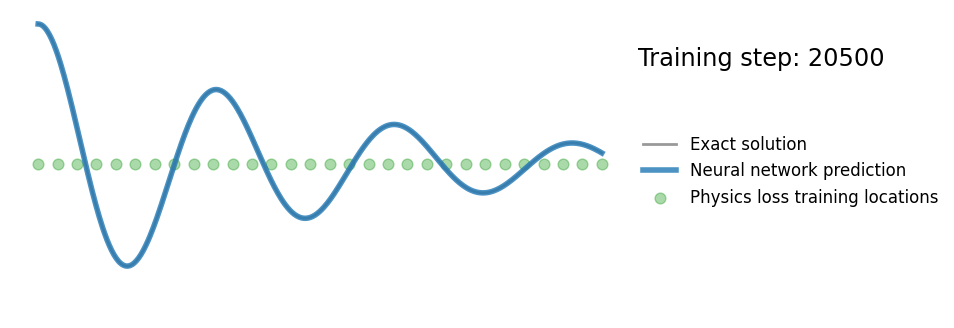

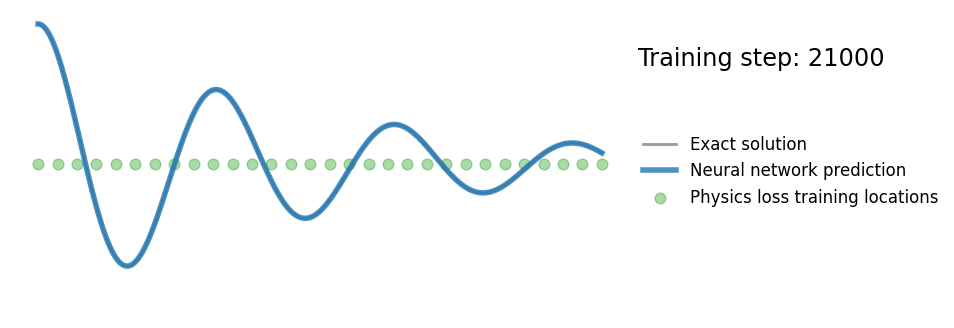

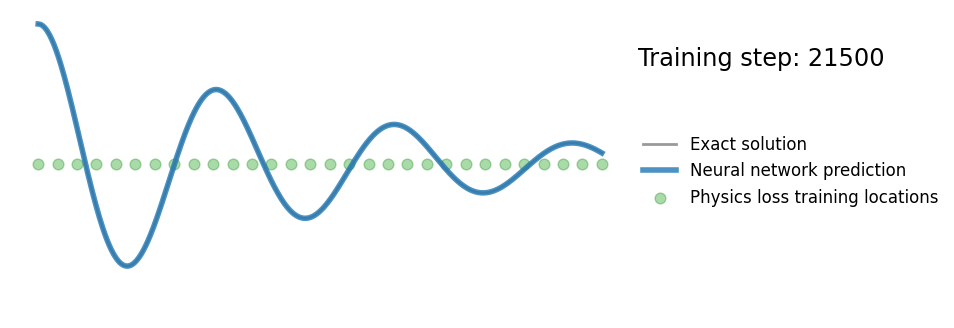

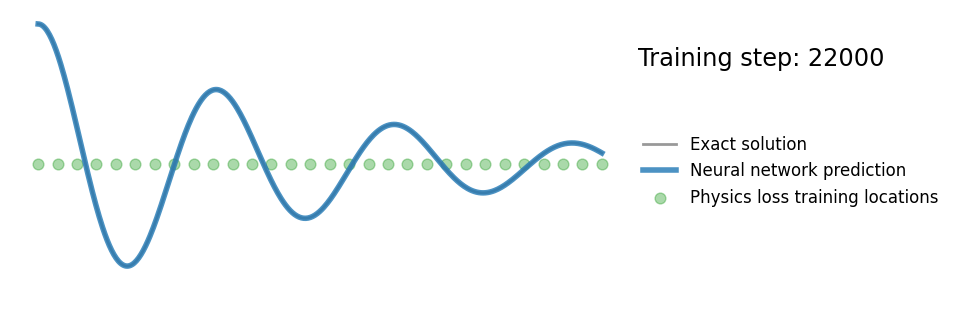

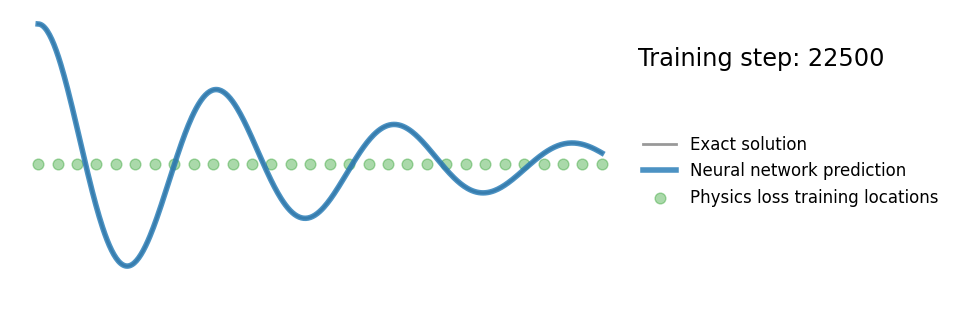

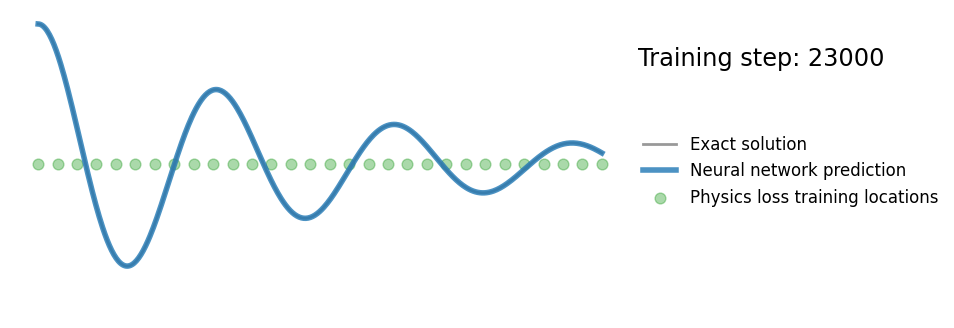

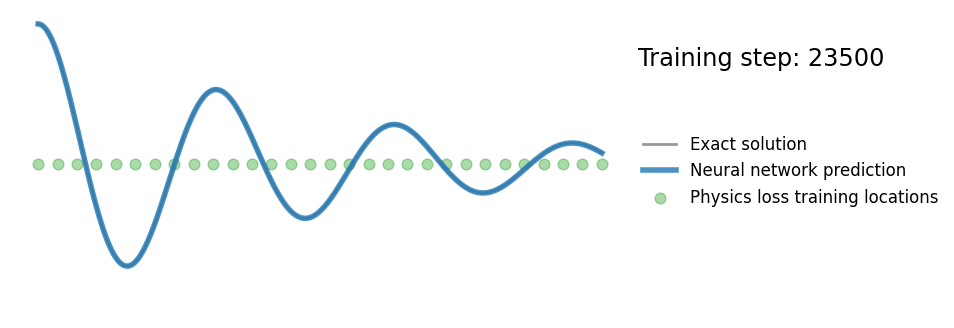

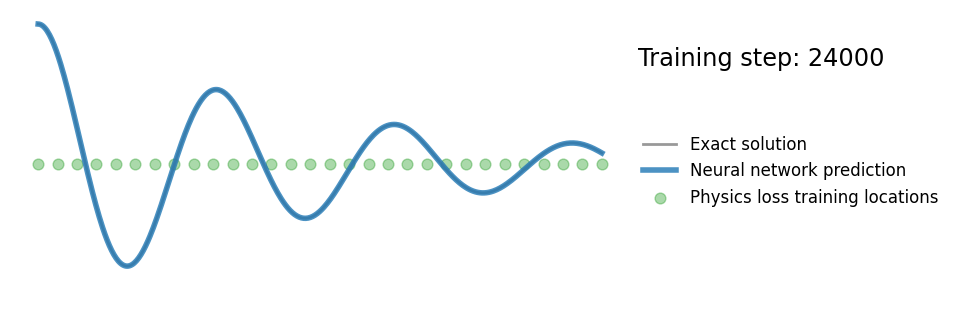

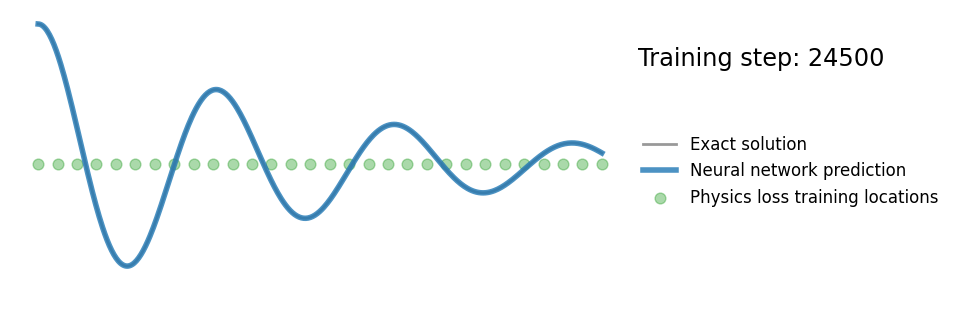

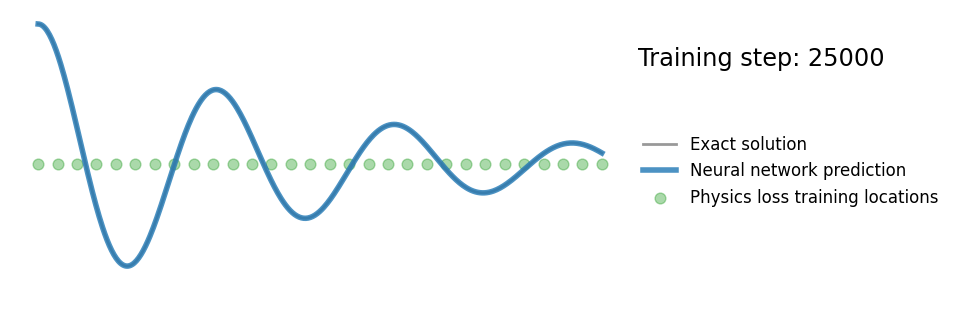

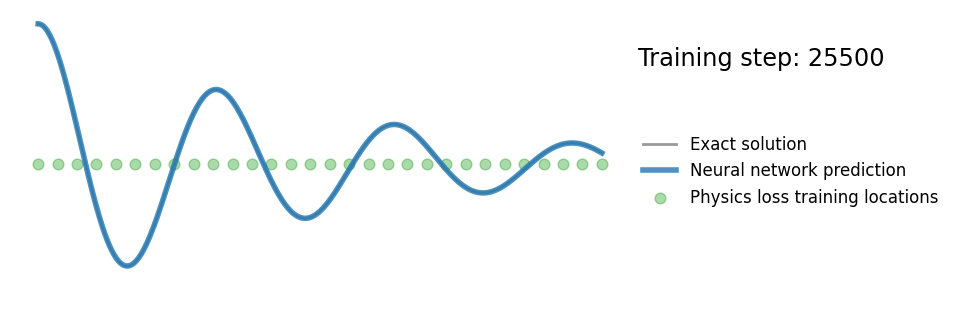

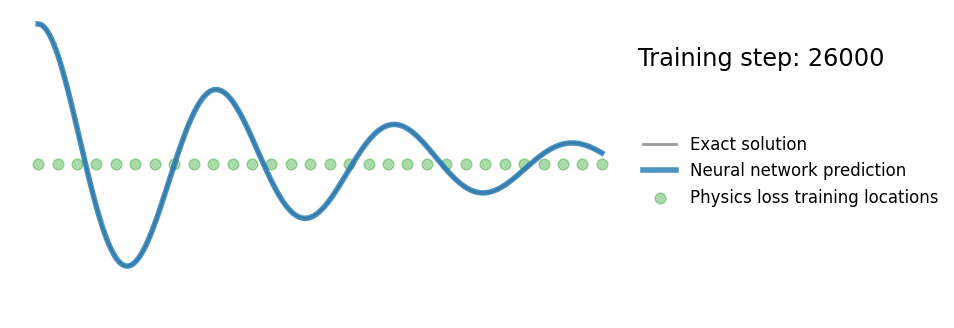

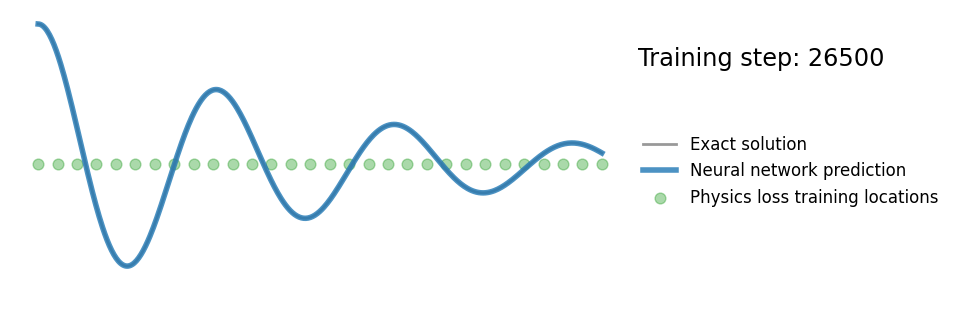

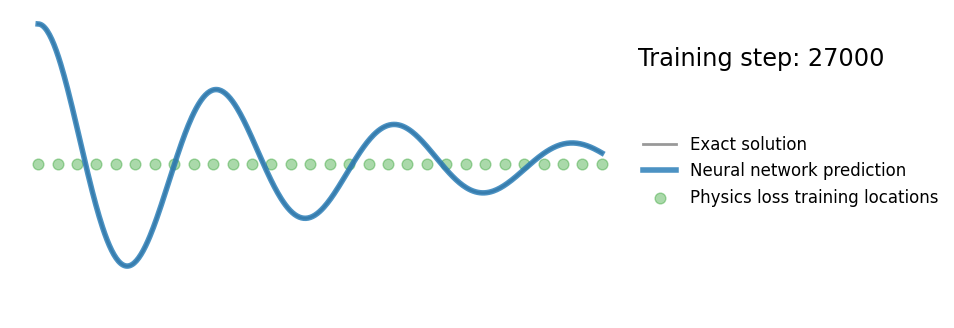

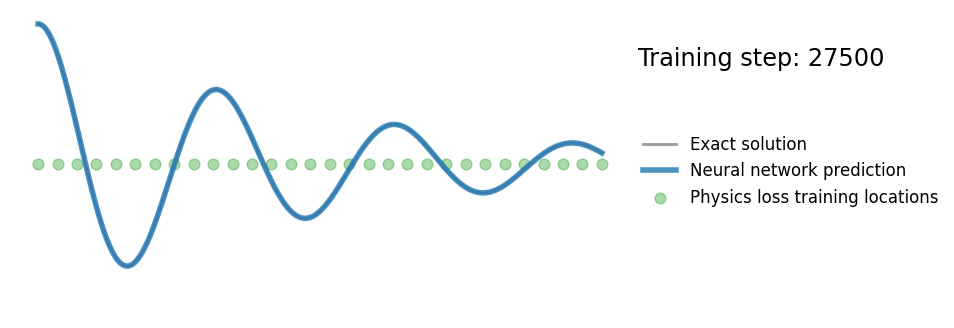

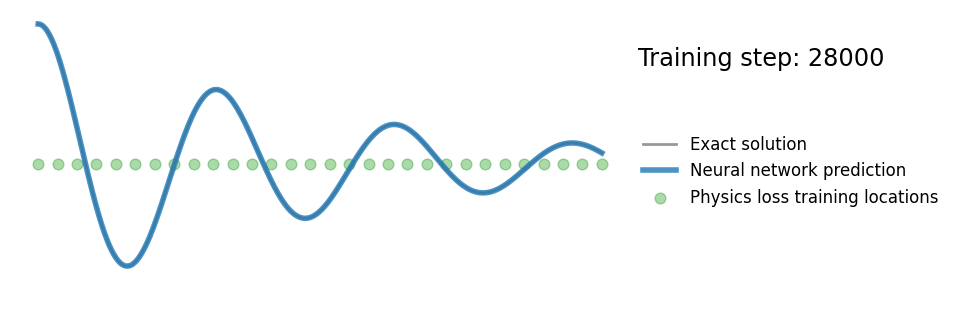

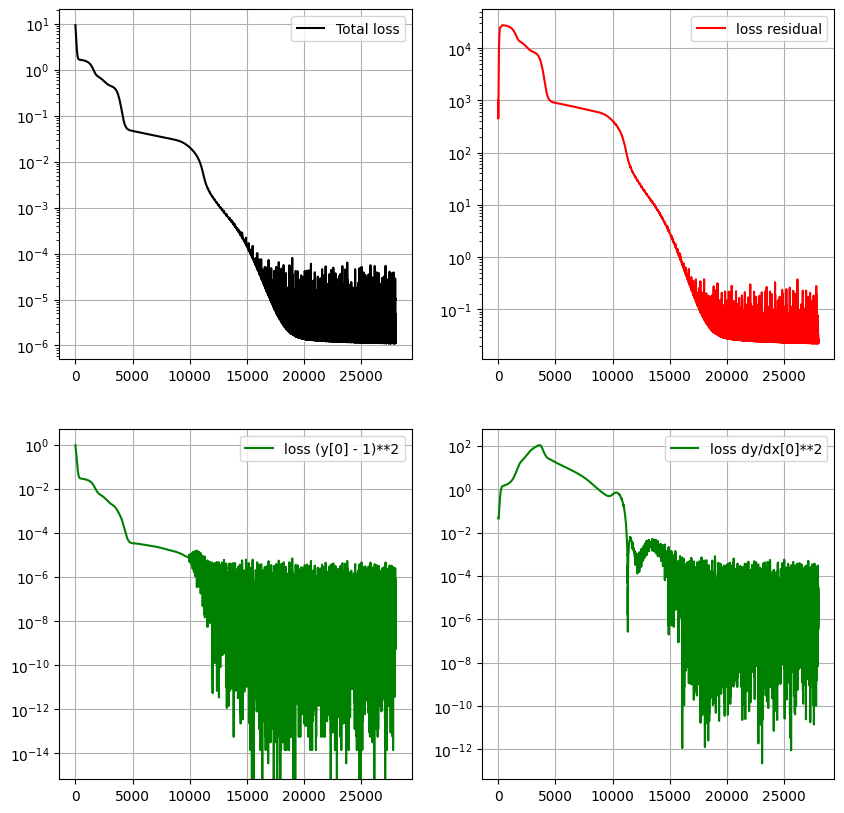

In [8]:
if __name__ == '__main__':
    torch.manual_seed(123)
    oscillator = Oscillator(dumping=2, pulsation=20)
    compute_pinn = True
    compute_from_data = False
    if compute_pinn:
        train_pinns(oscillator)
    if compute_from_data:
        train_from_data(oscillator)
    print("done!")

In [16]:
# !pip install deepxde

## **Helmholtz PDE example under Dirichlet Condition (with DeepXDE) : cas (a)**

For a wavenumber $k_0 = 2*π*n$ with n=2, we will solve a helmholtz equation :
$$  -u_{xx} - u_{yy} - k_0.u^2 = f $$

with the Dirichlet boundary conditions : $u = 0 \ $  in $\ ∂ \Omega $

and a source term : $f(x,y) = k_0^2.sin(k_0.x).sin(k_0.y)$

Remark that the exact solution reads: $u(x,y) = sin(k_0.x).sin(k_0.y)$
<br>
<br>
See DeepXDE documentation (tutorial on Helmholtz equation) and Github for more details.

This example is the Dirichlet boundary condition conterpart to this Dolfinx tutorial. One can refer to Ihlenburg's book "Finite Element Analysis of Acoustic Scattering" p138-139 for more details.

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

# General parameters
n = 2
precision_train = 30  # 10 initially
precision_test = 30
hard_constraint = True
weights = 100  # if hard_constraint == False
iterations = 30_000
parameters = [1e-3, 3, 150, "sin"]

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [4]:
# Define sine function
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
    print ("Pytorch")
elif dde.backend.backend_name == "paddle":
    sin = dde.backend.paddle.sin
    print ("Paddle")
else:
    from deepxde.backend import tf
    sin = tf.sin
    print ("Tensorflow")

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters     # the network has num_dense_layers hidden layer (+1 = num_total_layers)

Tensorflow


In [5]:
def pde(x, y):   #the first arg is the input (x and y), the second is the output (u)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    f = k0 ** 2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f


def func(x):   #the exact solution
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def transform(x, y):   #Applied only if hard constraint
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary

Collocation points density of 10 (resp. 30) points per wavelength for the training (resp. testing) data along each direction

In [6]:
# Defining Geometry, PDE (data object with train data and test data), train and test geometric steps (mesh)

geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

hx_train = wave_len / precision_train   #when precision is high, the step hx is small
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)


data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain= 4 * nx_train,   #nx_train ** 2,
    num_boundary= 4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

if hard_constraint == True:
    net.apply_output_transform(transform)


In [7]:
# Compiling the model
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, weights]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )

Compiling model...
Building feed-forward neural network...
'build' took 0.131136 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.816973 s



In [8]:
#Training the model
losshistory, train_state = model.train(iterations=iterations)

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.18e+03]    [6.44e+03]    [1.00e+00]    
1000      [3.99e+01]    [7.85e+01]    [3.70e-01]    
2000      [6.18e+00]    [1.04e+01]    [1.02e-01]    
3000      [3.75e-01]    [6.96e-01]    [2.34e-02]    
4000      [1.28e-01]    [2.40e-01]    [1.36e-02]    
5000      [7.09e-02]    [1.36e-01]    [8.52e-03]    
6000      [4.92e-02]    [9.79e-02]    [4.26e-03]    
7000      [9.80e-02]    [1.56e-01]    [4.55e-03]    
8000      [3.08e-02]    [6.51e-02]    [1.04e-03]    
9000      [1.54e+00]    [1.99e+00]    [1.65e-02]    
10000     [2.41e-02]    [5.34e-02]    [8.94e-04]    
11000     [5.09e-02]    [7.70e-02]    [3.42e-03]    
12000     [2.70e-02]    [5.29e-02]    [1.76e-03]    
13000     [3.64e-01]    [5.19e-01]    [9.77e-03]    
14000     [7.87e-02]    [1.19e-01]    [3.80e-03]    
15000     [1.91e-02]    [4.27e-02]    [1.27e-03]    
16000     [1.23e-01]    [1.71e-01]    [4.80e-03]    
17000     [2.24e-02]    [4.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


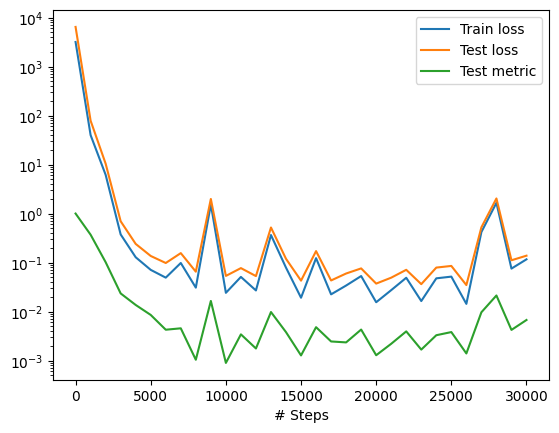

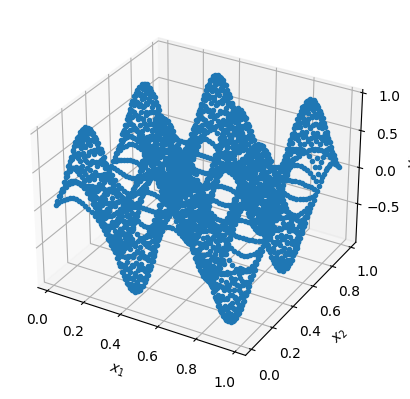

In [9]:
# Plotting the Losses & the Solution
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

* Notons l'instabilité des loss à partir d'un certain nombre d'itération
* Idée : changer l'optimiseur en ce moment (entraînement full batch ex. LBFGS)
* A investiguer : l'argument in_domain est ce que ça englobe la frontière et l'intérieur ou il s'agit uniquement de l'intérieur ?

## MY 1ST code with the library DeepXDE of a Helmoltz PDE (case b : specific boundary & no source | u is complex)

**STILL SOME DEBUGGING / MODIFICATION NEEDED !** \
* It deals with the case (b) in the project page (Helmoltz in C with a specific boundary condition & no source)

In [ ]:
import deepxde as dde
import numpy as np

# Define the Helmholtz equation and boundary conditions
def helmholtz_pde(x, y, omega):
    kx = np.sqrt(omega**2 / 2)
    ky = np.sqrt(omega**2 / 2)
    phi_real = np.exp(-1j * (kx * x + ky * y)).real
    phi_imag = np.exp(-1j * (kx * x + ky * y)).imag
    lap_phi_real = -kx**2 * phi_real - ky**2 * phi_real
    lap_phi_imag = -kx**2 * phi_imag - ky**2 * phi_imag
    eq_real = -lap_phi_real - omega**2 * phi_real
    eq_imag = -lap_phi_imag - omega**2 * phi_imag
    return eq_real, eq_imag

# Define the geometry of the domain
def geom():
    geom = dde.geometry.Rectangle([0, 0], [1, 1])
    return geom

# Define the boundary conditions
def boundary_conditions(x, on_boundary):
    return np.column_stack([x[:, 0], x[:, 1]])

# Create the DeepXDE data object
data = dde.data.PDE(geom(), helmholtz_pde, boundary_conditions, num_domain=10000, num_boundary=1000)
# data = dde.data.PDE(geom, helmholtz_pde, boundary_conditions, num_domain=10000, num_boundary=1000, num_collocation=1000)  #raised an error

# Define the neural network model
def model(x, y):
    # Define the neural network architecture
    net = dde.maps.FNN([2] + [32] * 3 + [2], "tanh", "Glorot normal")
    return net(x, y)

# Create the DeepXDE model
model = dde.Model(data, model)

# Define the loss function as a combination of the boundary and residual losses
loss = dde.loss.PDE(omega=1.0)
model.compile("adam", lr=0.001)    # lr
model.train(epochs=1000)    #Change number of epochs

# Evaluate the trained model
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
X = np.vstack((x.flatten(), y.flatten())).T
prediction = model.predict(X)

# Plot the real part of the solution
dde.plot.plot_points(X, prediction[:, 0].real, title="Real Part of Solution")

# Plot the imaginary part of the solution
dde.plot.plot_points(X, prediction[:, 1].real, title="Imaginary Part of Solution")